Source: https://github.com/NGYB/Stocks/blob/master/StockPricePrediction/StockPricePrediction_v1c_xgboost.ipynb

In [156]:
# data wrangling and linear algebra
import pandas as pd
import numpy as np

# cross validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

# models
import xgboost
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import pmdarima as pm

# visualisation
import matplotlib.pyplot as plt
import matplotlib

# error metrics
from sklearn import metrics

# misc
import warnings

warnings.filterwarnings(action='ignore')
matplotlib.rcParams['figure.figsize'] = (10,8)


In [5]:
msft = pd.read_csv('msft.csv')
msft = msft.set_index('Date')
msft

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-08-02,20.53,20.84,20.34,20.80,55044600,0.0,0
2010-08-03,20.70,20.82,20.52,20.67,56877700,0.0,0
2010-08-04,20.66,20.73,20.10,20.33,78531900,0.0,0
2010-08-05,20.14,20.21,19.92,20.04,64922100,0.0,0
2010-08-06,19.89,20.19,19.77,20.18,55982100,0.0,0
...,...,...,...,...,...,...,...
2020-07-24,200.42,202.86,197.51,201.30,39827000,0.0,0
2020-07-27,201.47,203.97,200.86,203.85,30160900,0.0,0
2020-07-28,203.61,204.70,201.74,202.02,23251400,0.0,0


<b> Univariate TS Modeling

In [25]:
close = msft[['Close']]

In [39]:
# predict for next 30 days
future_days = 30

close.loc[:,'prediction'] = close.shift(-future_days)

In [40]:
close.tail(30)

,Close,prediction
Date,,
2020-06-18,196.32,NaN
2020-06-19,195.15,NaN
2020-06-22,200.57,NaN
2020-06-23,201.91,NaN
2020-06-24,197.84,NaN
2020-06-25,200.34,NaN
2020-06-26,196.33,NaN
2020-06-29,198.44,NaN
2020-06-30,203.51,NaN


In [41]:
# splitting

X = close.drop(['prediction'], axis = 1)[:-future_days]
y = close['prediction'][:-future_days]

X_train, X_val ,y_train, y_val = train_test_split(X,y, test_size = 0.2, shuffle = False)

print('Training Size: ', X_train.shape, y_train.shape)
print('Validation Size: ', X_val.shape, y_val.shape)

Training Size:  (1989, 1) (1989,)
Validation Size:  (498, 1) (498,)


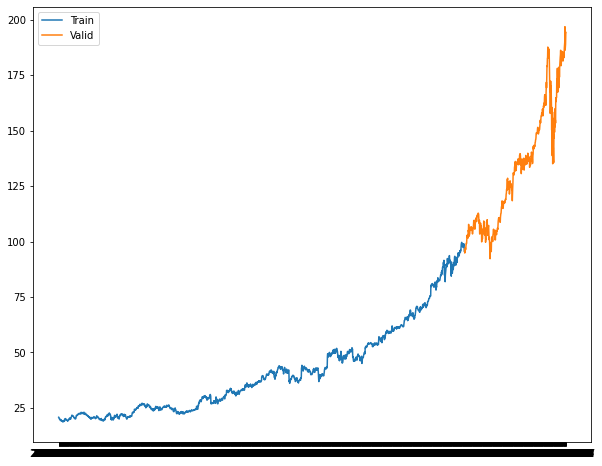

In [119]:
# plotting the split

plt.plot(X_train['Close'])
plt.plot(X_val['Close'])
plt.legend(['Train','Valid'])
plt.show()

In [47]:
# define models

reg = linear_model.LinearRegression()
tree = DecisionTreeRegressor()
rf = RandomForestRegressor(n_jobs=-1)
xgb = xgboost.XGBRegressor(n_jobs = -1)

models = [reg, tree, rf, xgb]

In [146]:
def plot_outputs(model):
    
    predictions = model.predict(X.tail(future_days)['Close'].values.reshape(-1,1))    
    valid = msft[['Close']][X.shape[0]:]
    valid['predictions'] = predictions
    
    plt.plot(X.Close)
    plt.plot(valid[['Close','predictions']])
    
    plt.legend(['Train','Valid','Pred'])
    plt.show()

In [152]:
def train_eval(models):
    """
    Trains and evaluates models and returns the best model with best score
    
    :params models: list of models
    
    returns: best_model
    """
    
    best_model = None
    best_score = 9999
    for model in models:
        model.fit(X_train,y_train)
        prediction = model.predict(X_val)
        
        rmse = metrics.mean_squared_error(y_val, prediction, squared = False)        
        print(f'RMSE:{str(model)[:3]} = {rmse}')
        
        if rmse < best_score:
            best_score = rmse
            best_model = model
        
    plot_outputs(best_model)
        
    return best_model

RMSE:Lin = 11.742783972749871
RMSE:Dec = 47.97888738328717
RMSE:Ran = 47.60259992372904
RMSE:XGB = 47.93806159504228


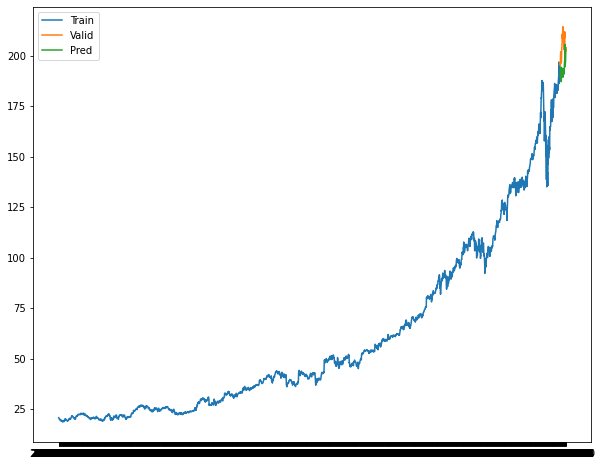

LinearRegression()

In [153]:
train_eval(models)

<B> ARIMA

In [158]:
df = msft.drop(['Dividends', 'Stock Splits'], axis = 1)

Auto Arima

In [203]:
model = pm.auto_arima(df['Close'],
                     m = 12,
                     start_p = 0,
                     seasonal = True,
                     start_q = 0,
                     max_order = 4,
                     test = 'adf',
                     error_action = 'ignore',
                     suppress_warnings=True,
                     stepwise=True,
                     trace=True)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(1,0,1,12) [intercept=True]; AIC=9241.891, BIC=9265.212, Time=1.541 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=9269.954, BIC=9281.615, Time=0.044 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=8975.636, BIC=8998.958, Time=0.665 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=8999.640, BIC=9022.962, Time=0.721 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=9273.672, BIC=9279.502, Time=0.038 seconds
Fit ARIMA(1,1,0)x(0,0,0,12) [intercept=True]; AIC=8984.326, BIC=9001.817, Time=0.169 seconds
Fit ARIMA(1,1,0)x(2,0,0,12) [intercept=True]; AIC=8971.487, BIC=9000.639, Time=2.208 seconds
Fit ARIMA(1,1,0)x(2,0,1,12) [intercept=True]; AIC=8973.014, BIC=9007.997, Time=5.732 seconds
Fit ARIMA(1,1,0)x(1,0,1,12) [intercept=True]; AIC=8972.225, BIC=9001.377, Time=1.761 seconds
Fit ARIMA(0,1,0)x(2,0,0,12) [intercept=True]; AIC=9239.920, BIC=9263.242, Time=2.091 seconds
Fit ARIMA(2,1,0)x(2,0,0,12

In [204]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 2517
Model:             SARIMAX(3, 1, 2)x(0, 0, [1], 12)   Log Likelihood               -4407.679
Date:                              Sat, 01 Aug 2020   AIC                           8831.358
Time:                                      18:17:37   BIC                           8878.001
Sample:                                           0   HQIC                          8848.286
                                             - 2517                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3357      0.111      3.018      0.003       0.118       0.554
ar.L1         -2.0366      0.014   -144.379      0.000      -2.064      -2.009
ar.L2         -1.3598      0.021    -65.703      0.000      -1.400      -1.319
ar.L3         -0.2250      0.009    -24.037      0.000      -0.243      -0.207
ma.L1          1.7677      0.012    146.455      0.000       1.744       1.791
ma.L2          0.8632      0.011     80.403      0.000       0.842       0.884
ma.S.L12       0.0364      0.007      4.873      0.000       0.022       0.051
sigma2         1.9446      0.016    119.060      0.000       1.913       1.977
===================================================================================
Ljung-Box (Q):                      144.39   Jarque-Bera (JB):             75199.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              36.59   Skew:                            -0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Auto Arima selected SARIMAX as the best model

In [207]:
# splitting data

test_size = 0.2
train_num = int(len(df)*(1-test_size))
print(train_num)

train = df.iloc[:train_num]
test = df.iloc[train_num:]

2013


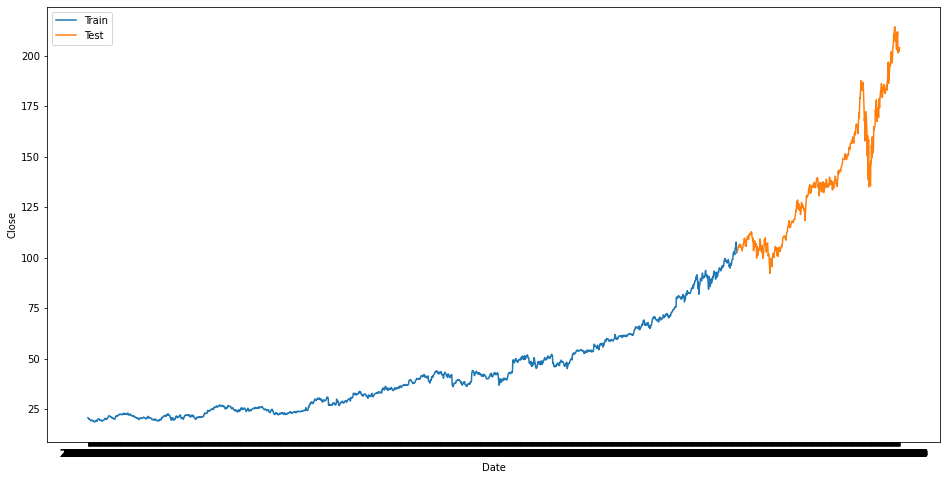

In [170]:
# plotting the data
plt.figure(figsize=(16,8))

plt.plot(train['Close'])
plt.plot(test['Close'])

plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

In [208]:
# fitting the model
model.fit(train['Close'])

ARIMA(order=(3, 1, 2), seasonal_order=(0, 0, 1, 12), suppress_warnings=True)

In [209]:
# forecast
forecast = model.predict(n_periods = len(test), return_conf_int = True) 

lower = forecast[1][:,0]
upper = forecast[1][:,1]

In [210]:
forecast_df = pd.DataFrame(forecast[0], columns=['forecast'], index = test.index)
forecast_df['original'] = test['Close']
forecast_df['lower'] = lower
forecast_df['upper'] = upper

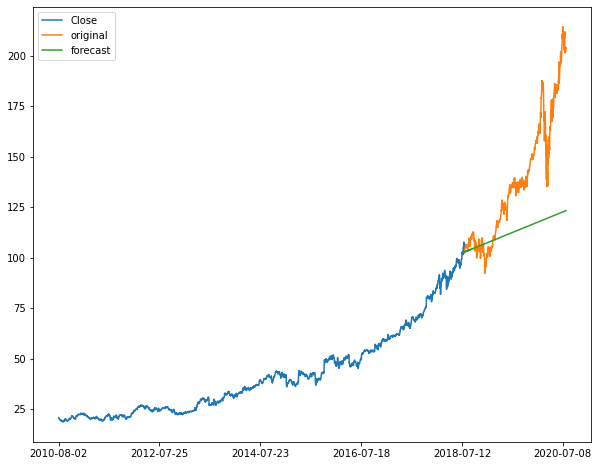

In [211]:
pd.concat([train['Close'], forecast_df['original'], forecast_df['forecast']], axis = 1).plot()

In [212]:
# check rmse

print('RMSE ARIMA: ', metrics.mean_squared_error(forecast_df['original'], forecast_df['forecast'], squared = False))


RMSE ARIMA:  35.43885003395963


Auto ARIMA on Weekly trend

In [223]:
df.index = pd.to_datetime(df.index)

In [233]:
df_weekly = df.resample('W').mean()
df_weekly

,Open,High,Low,Close,Volume
Date,,,,,
2010-08-08,20.384,20.558,20.130,20.4040,62271680.0
2010-08-15,19.644,19.802,19.496,19.6600,67321020.0
2010-08-22,19.464,19.622,19.316,19.4660,48853180.0
2010-08-29,19.140,19.288,18.966,19.0880,55123000.0
2010-09-05,18.922,19.046,18.802,18.9380,57957960.0
...,...,...,...,...,...
2020-07-05,200.620,204.325,199.515,203.2275,30597225.0
2020-07-12,211.860,213.904,209.464,211.9540,31679520.0
2020-07-19,208.008,209.344,203.452,206.0520,33896560.0


In [237]:
# splitting
train_num = int(len(df_weekly)*(1-test_size))

trainw = df_weekly.iloc[:train_num]
testw = df_weekly.iloc[train_num:]

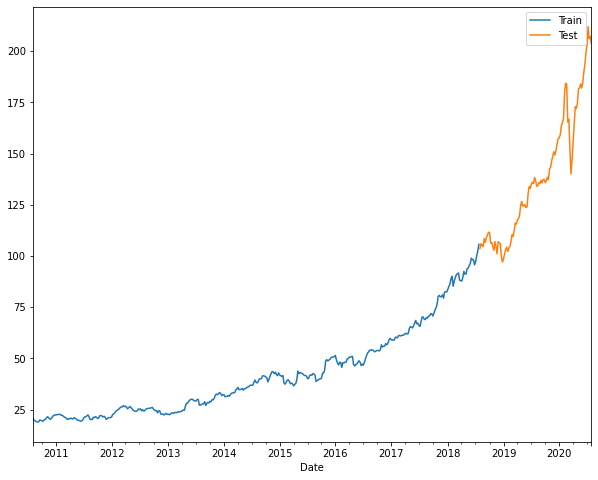

In [239]:
# visualising

pd.concat([trainw['Close'], testw['Close']], axis = 1).plot()
plt.legend(['Train','Test'])
plt.show()

In [250]:
# Auto Arima

model = pm.auto_arima(df_weekly['Close'],
                     m = 12,
                     start_p = 0,
                     seasonal = False,
                     start_q = 0,
                     max_order = 4,
                     test = 'adf',
                     error_action = 'ignore',
                     suppress_warnings=True,
                     stepwise=True,
                     trace=True)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2259.393, BIC=2267.904, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2242.237, BIC=2255.004, Time=0.048 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2244.265, BIC=2257.032, Time=0.060 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2271.674, BIC=2275.930, Time=0.011 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=2243.118, BIC=2260.141, Time=0.088 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2243.435, BIC=2260.458, Time=0.097 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=2245.116, BIC=2266.394, Time=0.166 seconds
Total fit time: 0.489 seconds


In [251]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  522
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1118.119
Date:                Sat, 01 Aug 2020   AIC                           2242.237
Time:                        18:29:06   BIC                           2255.004
Sample:                             0   HQIC                          2247.238
                                - 522                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2825      0.095      2.973      0.003       0.096       0.469
ar.L1          0.1906      0.018     10.803      0.000       0.156       0.225
sigma2         4.2812      0.082     52.366      0.000       4.121       4.441
===================================================================================
Ljung-Box (Q):                       96.83   Jarque-Bera (JB):             10040.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              27.05   Skew:                            -1.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [252]:
model.fit(trainw['Close'])

ARIMA(order=(1, 1, 0), suppress_warnings=True)

In [253]:
# forecast
forecast = model.predict(n_periods = len(testw), return_conf_int = True) 

lower = forecast[1][:,0]
upper = forecast[1][:,1]

In [254]:
forecast_df = pd.DataFrame(forecast[0], columns=['forecast'], index = testw.index)
forecast_df['original'] = testw['Close']
forecast_df['lower'] = lower
forecast_df['upper'] = upper

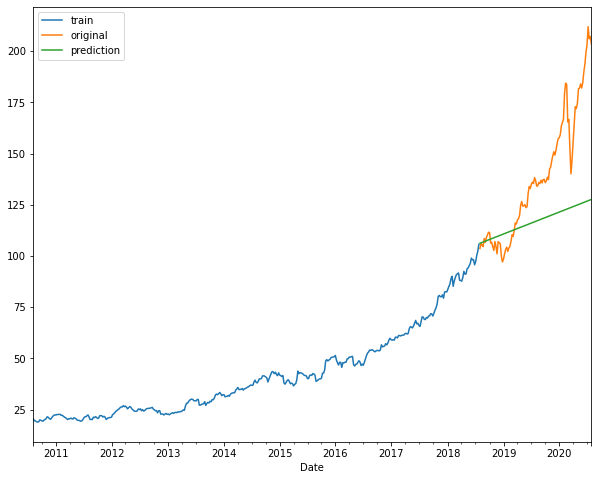

In [255]:
pd.concat([trainw['Close'], forecast_df['original'], forecast_df['forecast']], axis = 1).plot()
plt.legend(['train', 'original', 'prediction'])

In [257]:
print('RMSE weekly ARIMA: ', metrics.mean_squared_error(testw['Close'],forecast_df['forecast'], squared=False))

RMSE weekly ARIMA:  32.67285020032801


Monthly ARIMA

In [258]:
df_monthly = df.resample('M').mean()

In [259]:
# Auto Arima

model = pm.auto_arima(df_monthly['Close'],
                     m = 12,
                     start_p = 0,
                     seasonal = False,
                     start_q = 0,
                     max_order = 4,
                     test = 'adf',
                     error_action = 'ignore',
                     suppress_warnings=True,
                     stepwise=True,
                     trace=True)

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=688.676, BIC=694.234, Time=0.007 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=690.585, BIC=698.922, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=690.597, BIC=698.934, Time=0.043 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=701.707, BIC=704.486, Time=0.006 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=684.313, BIC=695.429, Time=0.148 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=684.702, BIC=698.597, Time=0.152 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=684.358, BIC=698.253, Time=0.248 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=691.743, BIC=702.859, Time=0.056 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=691.878, BIC=702.994, Time=0.039 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=689.889, BIC=706.564, Time=0.348 seconds
Total fit time: 1.079 seconds


In [260]:
# splitting
train_num = int(len(df_monthly)*(1-test_size))
print(train_num)

train = df_monthly.iloc[:train_num]
test = df_monthly.iloc[train_num:]

96


In [261]:
model.fit(train['Close'])

ARIMA(order=(1, 1, 1), suppress_warnings=True)

In [262]:
# forecast
forecast = model.predict(n_periods = len(test), return_conf_int = True) 

lower = forecast[1][:,0]
upper = forecast[1][:,1]

In [265]:
forecast_df = pd.DataFrame(forecast[0], columns=['forecast'], index = test.index)
forecast_df['original'] = test['Close']
forecast_df['lower'] = lower
forecast_df['upper'] = upper

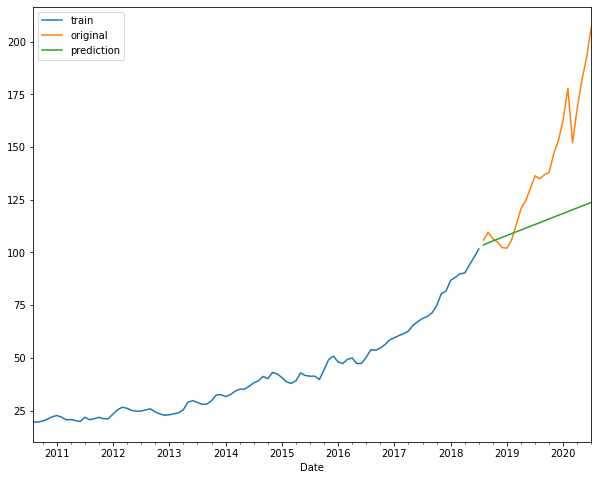

In [266]:
pd.concat([train['Close'], forecast_df['original'], forecast_df['forecast']], axis = 1).plot()
plt.legend(['train', 'original', 'prediction'])

Arima not giving good results till now